In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
from scipy.fft import fft, ifft

In [3]:
data_dir = '/glade/u/home/marsh/scratch/LMD/LMD_MARS_r2801_Mg_17Oct2022/'
ds = xr.open_dataset(data_dir+'LMD_MARS_r2801_Mg_17Oct2022_diagfi_MY32_01.nc', decode_times=False)

In [4]:
ds

<xarray.Dataset>
Dimensions:              (index: 100, latitude: 49, longitude: 65, altitude: 49, interlayer: 50, subsurface_layers: 18)
Coordinates:
  * latitude             (latitude) float64 90.0 86.25 82.5 ... -86.25 -90.0
  * longitude            (longitude) float64 -180.0 -174.4 ... 174.4 180.0
  * altitude             (altitude) float64 0.004481 0.02354 ... 234.3 241.3
Dimensions without coordinates: index, interlayer, subsurface_layers
Data variables: (12/254)
    Time                 float32 ...
    controle             (index) float64 ...
    aps                  (altitude) float32 ...
    bps                  (altitude) float32 ...
    ap                   (interlayer) float32 ...
    bp                   (interlayer) float32 ...
    ...                   ...
    PhiH2                float32 ...
    PhiD                 float32 ...
    zmax_th              (latitude, longitude) float32 ...
    hfmax_th             (latitude, longitude) float32 ...
    wstar                (latitude, longitude) float32 ...
    co2conservation      float32 ...
Attributes:
    history:  Wed Nov 30 21:46:31 2022: ncwa -O -a Time /resstore/b0154/Data/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

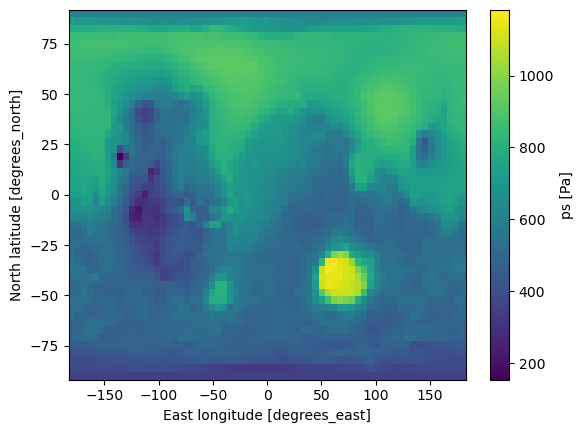

In [5]:
ds.ps.plot()
plt.show()

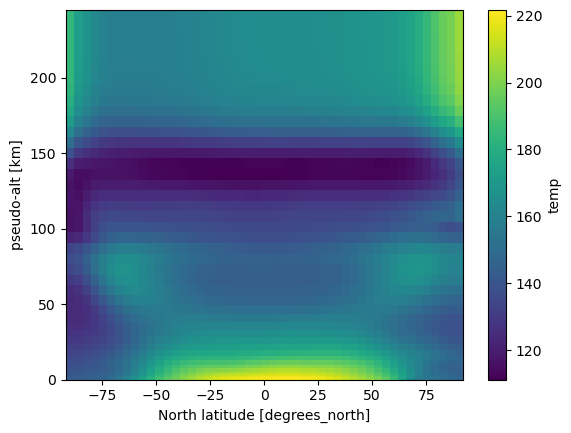

In [6]:
ds.temp.mean(dim='longitude').plot()
plt.show()

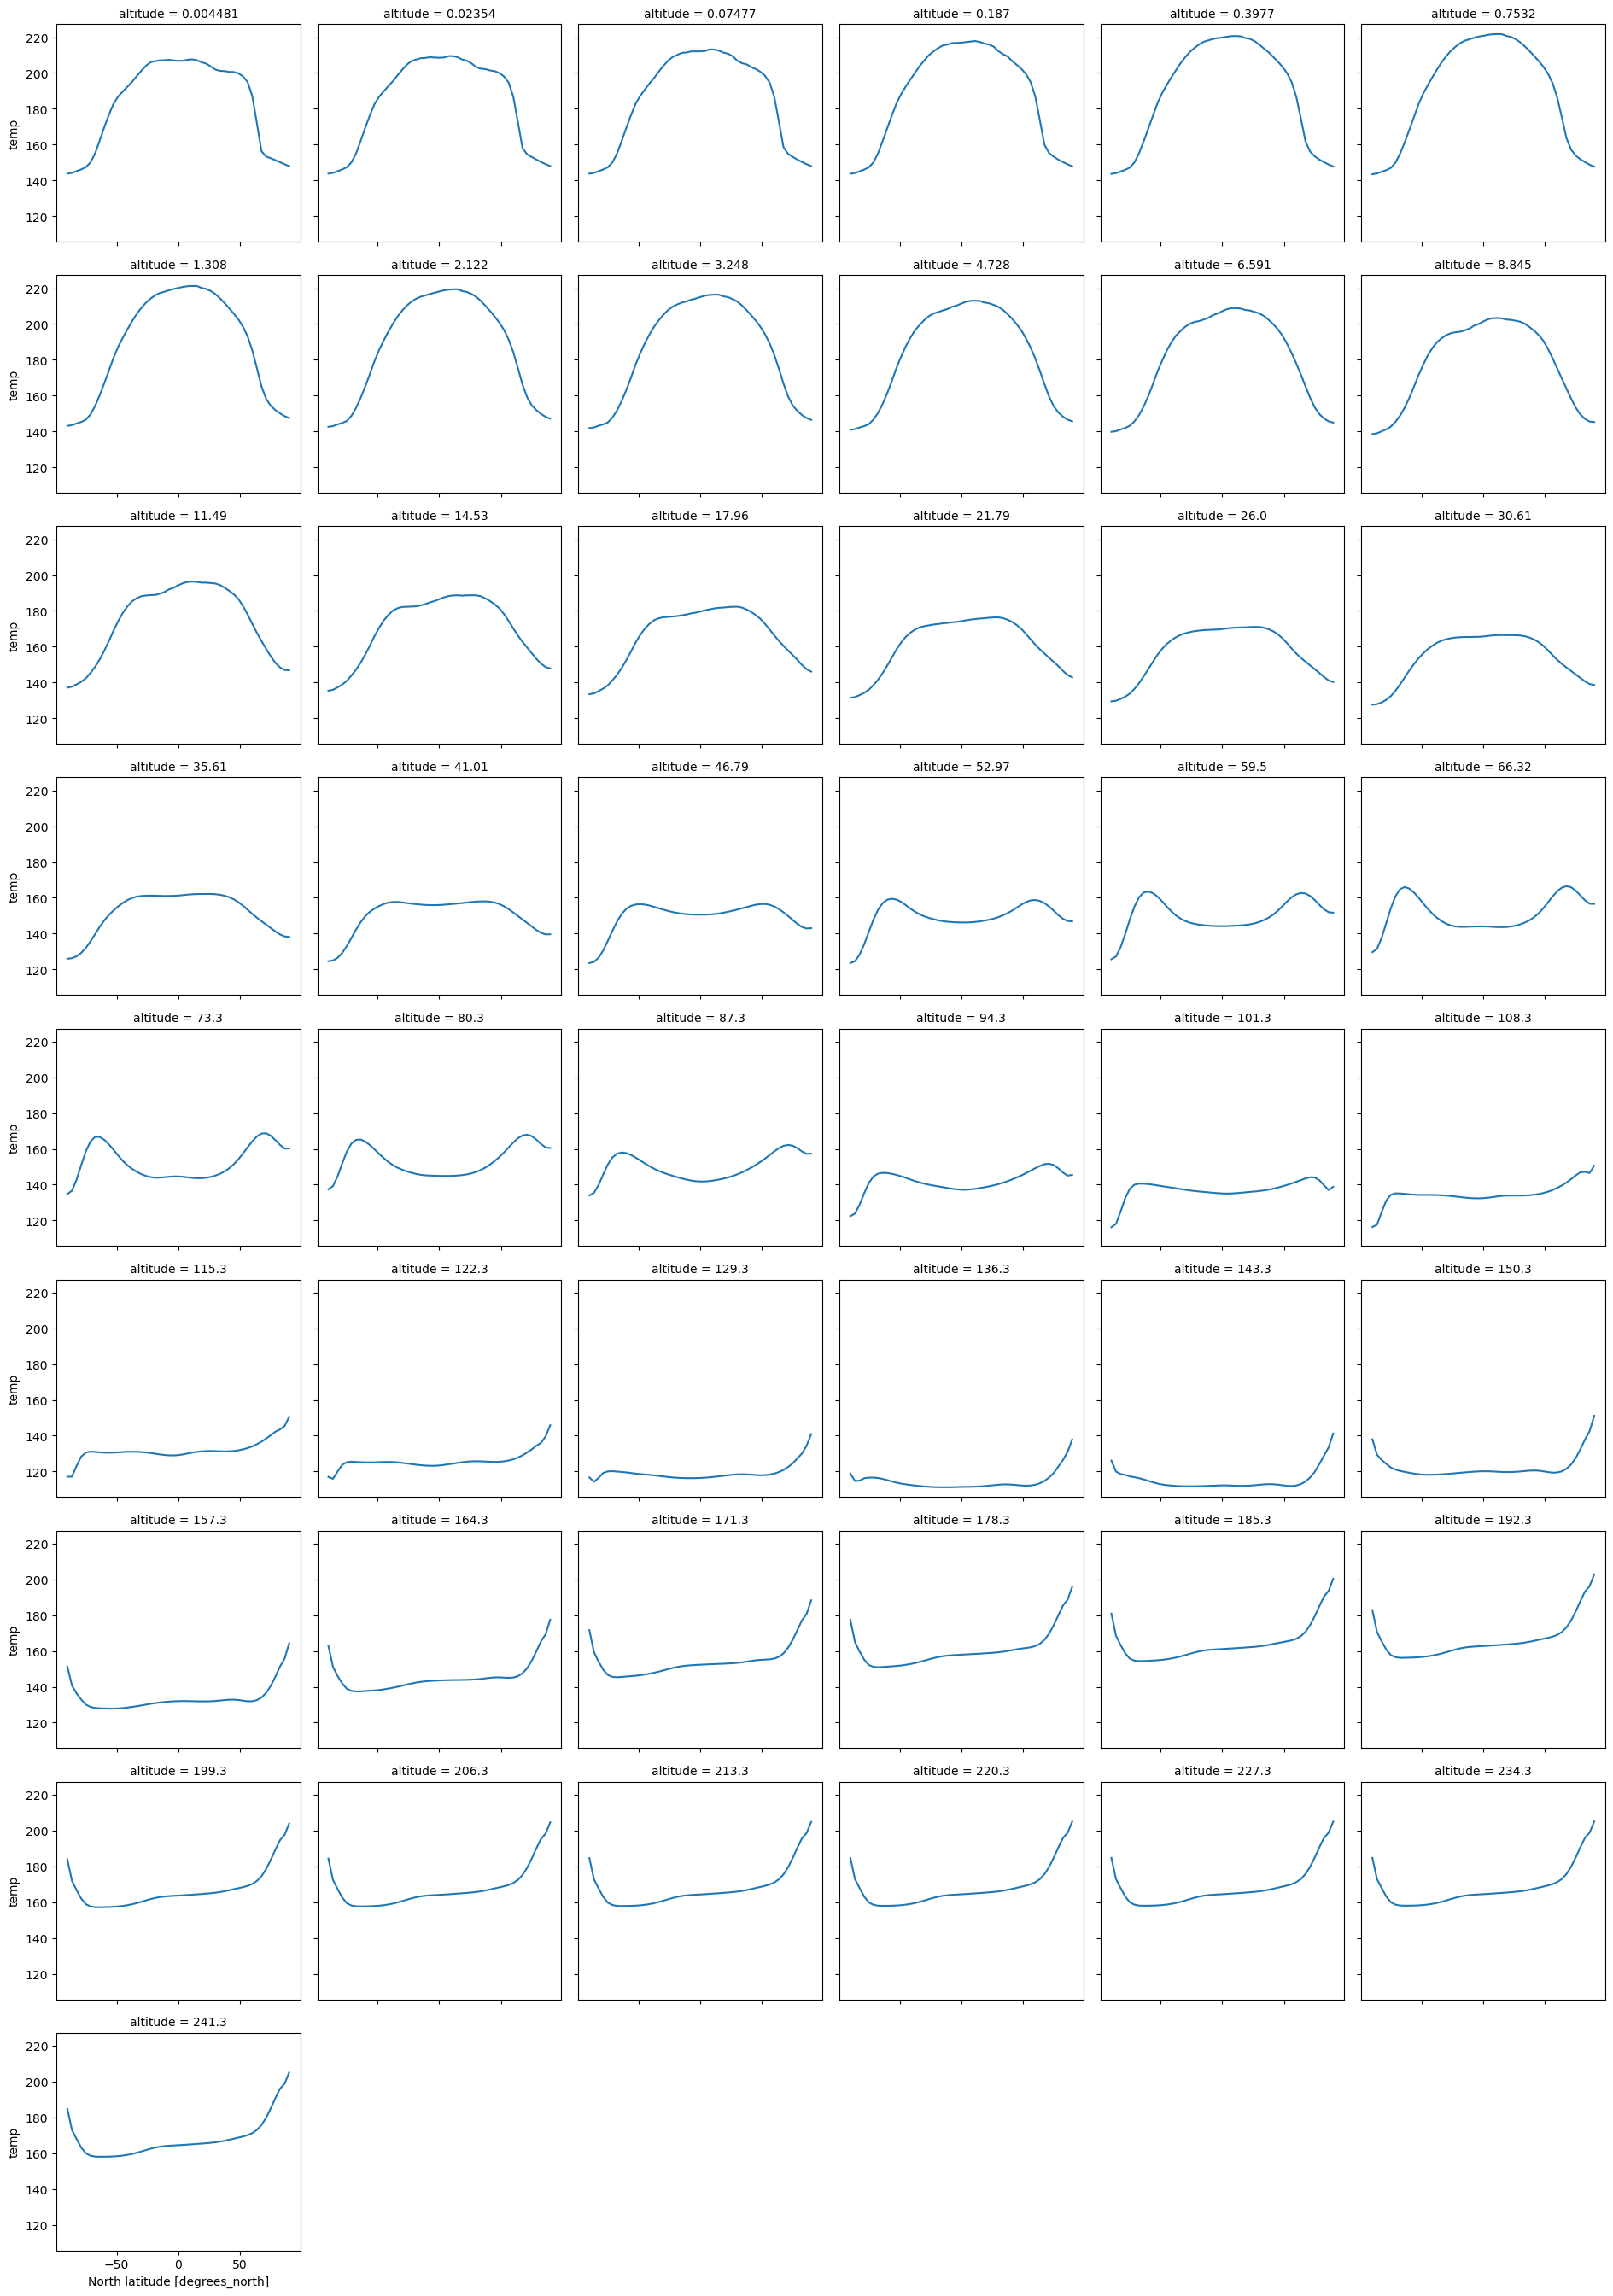

In [7]:
ds.temp.mean(dim='longitude').plot(col="altitude", col_wrap=6)
plt.show()

In [8]:
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

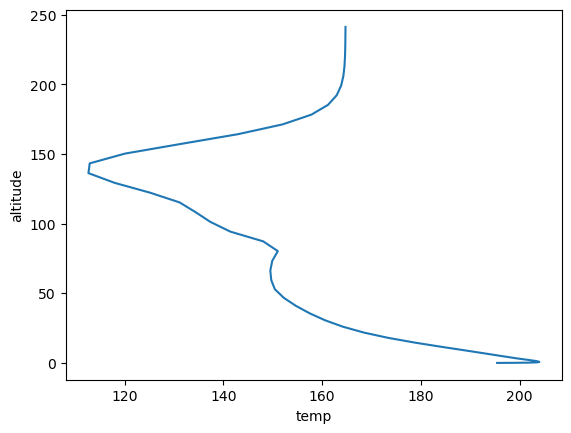

In [9]:
gmt = ds.temp.weighted(weights).mean(("longitude", "latitude"))
gmt.plot(y='altitude')
plt.show()

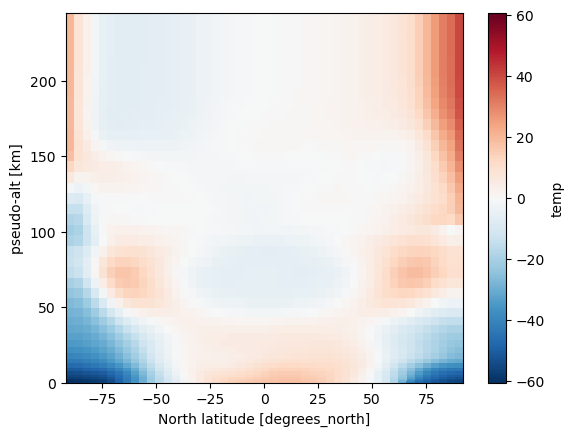

In [10]:
(ds.temp.mean(dim='longitude')-gmt).plot()
plt.show()

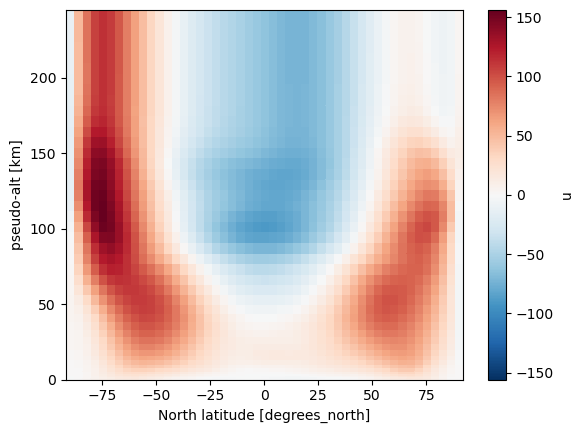

In [11]:
ds.u.mean(dim='longitude').plot()
plt.show()

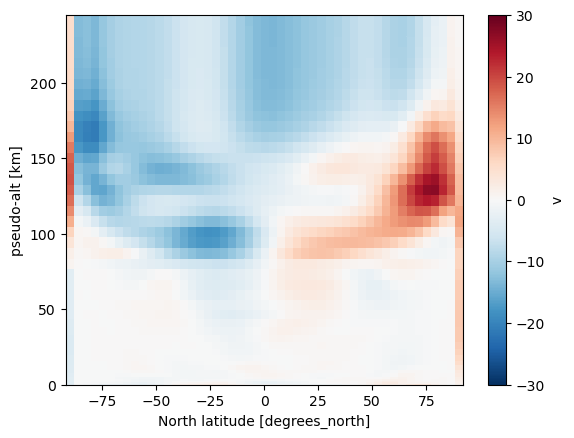

In [12]:
ds.v.mean(dim='longitude').plot(vmin=-30)
plt.show()

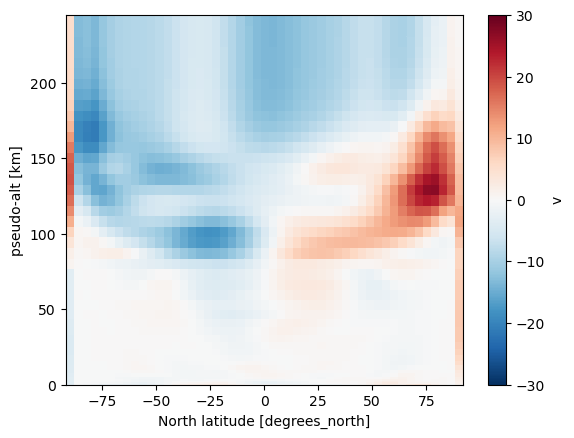

In [13]:
ds.v.mean(dim='longitude').plot(vmin=-30)
plt.show()

In [14]:
ds.latitude.values

array([ 90.  ,  86.25,  82.5 ,  78.75,  75.  ,  71.25,  67.5 ,  63.75,
        60.  ,  56.25,  52.5 ,  48.75,  45.  ,  41.25,  37.5 ,  33.75,
        30.  ,  26.25,  22.5 ,  18.75,  15.  ,  11.25,   7.5 ,   3.75,
         0.  ,  -3.75,  -7.5 , -11.25, -15.  , -18.75, -22.5 , -26.25,
       -30.  , -33.75, -37.5 , -41.25, -45.  , -48.75, -52.5 , -56.25,
       -60.  , -63.75, -67.5 , -71.25, -75.  , -78.75, -82.5 , -86.25,
       -90.  ])

In [15]:
ds.longitude.values

array([-180.   , -174.375, -168.75 , -163.125, -157.5  , -151.875,
       -146.25 , -140.625, -135.   , -129.375, -123.75 , -118.125,
       -112.5  , -106.875, -101.25 ,  -95.625,  -90.   ,  -84.375,
        -78.75 ,  -73.125,  -67.5  ,  -61.875,  -56.25 ,  -50.625,
        -45.   ,  -39.375,  -33.75 ,  -28.125,  -22.5  ,  -16.875,
        -11.25 ,   -5.625,    0.   ,    5.625,   11.25 ,   16.875,
         22.5  ,   28.125,   33.75 ,   39.375,   45.   ,   50.625,
         56.25 ,   61.875,   67.5  ,   73.125,   78.75 ,   84.375,
         90.   ,   95.625,  101.25 ,  106.875,  112.5  ,  118.125,
        123.75 ,  129.375,  135.   ,  140.625,  146.25 ,  151.875,
        157.5  ,  163.125,  168.75 ,  174.375,  180.   ])

In [21]:
tzm = ds.temp.mean(dim='longitude')
tbar = tzm.mean(dim='latitude')

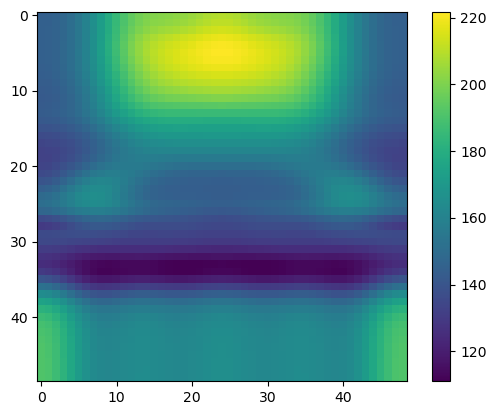

In [57]:
fit = np.zeros((49,49))
amp = np.zeros((49,5))
amp[:,0] = tbar.values
lat = np.radians(ds.latitude.values)
# note fft assumes domain is 0 to 2pi
# so take lat (-pi/2 to pi/2), add pi/2 and multiply by 2
y = 2.*(lat+0.5*np.pi)
t2d = (tzm-tbar)

for i in np.arange(49):
    t1d = t2d.isel(altitude=i).values
    Z = ifft(t1d) 
    
    amp[i,1:5] = 2.*np.real(Z[1:5])
    fit[i,:] = amp[i,0] \
             + amp[i,1]*np.cos(y) \
             + amp[i,2]*np.cos(2*y) \
             + amp[i,3]*np.cos(3*y) \
             + amp[i,4]*np.cos(4*y)
    
im = plt.imshow(fit)

plt.colorbar(im)
plt.show()

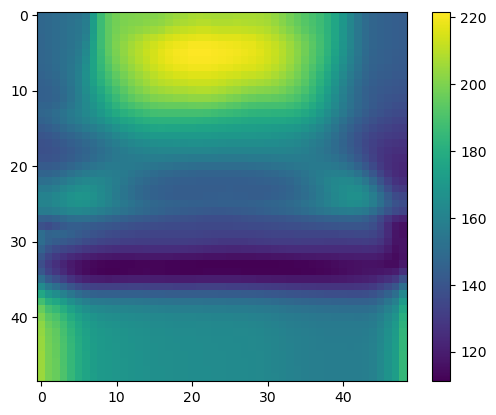

In [48]:
im = plt.imshow(tzm.values)
plt.colorbar(im)

plt.show()

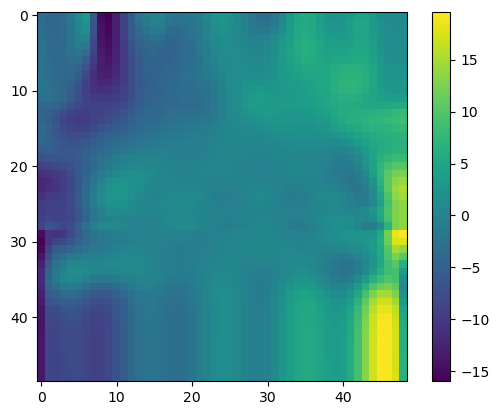

In [50]:
im = plt.imshow(fit-tzm.values)
plt.colorbar(im)
plt.show()

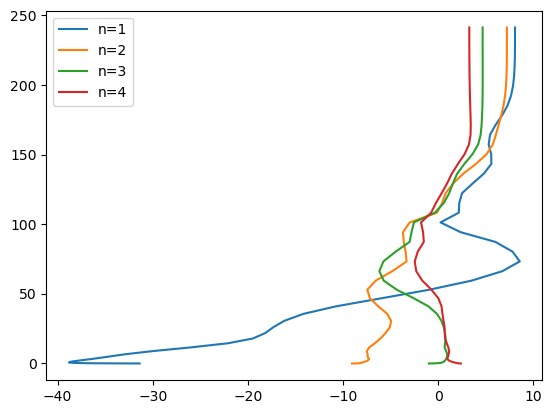

In [52]:
levels = ds.altitude.values
plt.plot(amp[:,1],levels, label='n=1')
plt.plot(amp[:,2],levels, label='n=2')
plt.plot(amp[:,3],levels, label='n=3')
plt.plot(amp[:,4],levels, label='n=4')

plt.legend()
plt.show()

In [53]:
data = np.column_stack((ds.altitude.values, amp))
np.savetxt('amplitudes.dat', np.flip(data, axis=0))

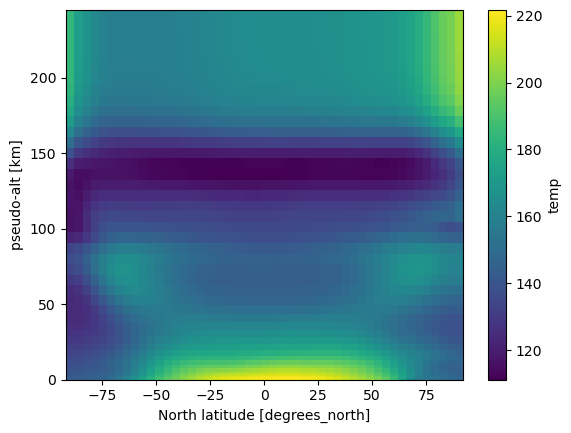

In [55]:
# plot on pseudo-alt coordinates

tzm.plot()
plt.show()

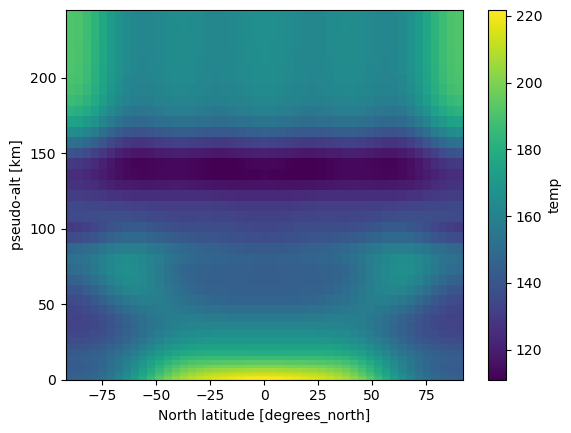

In [56]:
tzmfit = tzm.copy()
tzmfit.values = fit
tzmfit.plot()
plt.show()
